In [20]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.impute import SimpleImputer
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
df1 = pd.read_csv('./0507_cleaned_booking_hotels.csv')
df2 = pd.read_csv('./2506_cleaned_booking_hotels.csv')
df3 = pd.read_csv('./20_06_hotels_data_cleaned.csv')

# Merge the dataframes
df = pd.concat([df1, df2, df3], ignore_index=True)
df.shape

(75761, 25)

## Removal of exceptions according to the Tukey method (IQR1.5)

In [21]:
# Assuming 'price_per_night' is already numerical
df['price_per_night'] = df['price_per_night'].astype(float)

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['price_per_night'].quantile(0.25)
Q3 = df['price_per_night'].quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Determine the lower and upper bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers
df_no_outliers = df[(df['price_per_night'] >= lower_bound) & (df['price_per_night'] <= upper_bound)]

print(f"Original DataFrame shape: {df.shape}")
print(f"DataFrame shape after removing outliers: {df_no_outliers.shape}")

df_no_outliers.to_csv('./United_cleaned_booking_hotels.csv', index=False)


df_no_outliers.T

Original DataFrame shape: (75761, 25)
DataFrame shape after removing outliers: (74640, 25)


,0,1,2,3,4,5,6,7,8,9,...,75751,75752,75753,75754,75755,75756,75757,75758,75759,75760
name,U.S. Pacific Hotel,West Side YMCA,Hudson Yard 408,The Gatsby Hotel,Orchard Street Hotel,Chelsea Rooms NYC,"Hotel Shocard Broadway, Times Square",The Frederick Hotel Tribeca,Courtyard New York Downtown Manhattan/Financia...,Doxie Hotel,...,Nolitan Hotel SoHo - New York,Hilton Garden Inn New York Times Square North,Chelsea Pines Inn,"Distrikt Hotel New York City, Tapestry Collect...",Henn na Hotel New York,Fairfield Inn & Suites by Marriott New York Ma...,Freehand New York,American Dream Guest House,Courtyard by Marriott Times Square West,Radio City Apartments
score,5.6,6.6,4.4,6.3,6.7,7.5,7.3,8.0,7.5,6.8,...,8.0,7.7,7.9,7.5,8.5,8.2,7.8,9.0,8.2,8.5
reviews,2473.0,13729.0,61.0,689.0,642.0,703.0,2434.0,2271.0,1711.0,622.0,...,1388.0,2811.0,1739.0,345.0,3104.0,6793.0,1877.0,4.0,2796.0,5980.0
room_type,Standard Double (No Window),Bunk Bed Room with Shared Bathroom,Double Room,Gatsby Full,Orchard Full,Deluxe Double Room,Queen Room,Standard 1 Full Bed,"Guest room, 1 King, City view",Queen Room,...,Deluxe Queen Room,King Room,Standard Double Room,Queen Room,Handicap Accessible Room,1 King Bed,Premium Queen,Double Room with Shared Bathroom,King Room,Queen Studio
bed_type,New YorkShow on map5.7 km from centreMetro ac...,New YorkShow on map350 m from centreMetro access,New YorkShow on map1.9 km from centreMetro ac...,New YorkShow on map5 km from centreMetro access,New YorkShow on map5.3 km from centreMetro ac...,New YorkShow on map2.5 km from centreMetro ac...,New YorkShow on map1.5 km from centreMetro ac...,New YorkShow on map6.3 km from centreMetro ac...,New YorkShow on map7.1 km from centreMetro ac...,New YorkShow on map1.7 km from centreMetro ac...,...,New YorkShow on map5.4 km from centreMetro ac...,New YorkShow on map1.3 km from centreMetro ac...,New YorkShow on map3.6 km from centreMetro ac...,New YorkShow on map1.6 km from centreMetro ac...,New YorkShow on map1.9 km from centreMetro ac...,New YorkShow on map1.9 km from centreMetro ac...,New YorkShow on map3.1 km from centreMetro ac...,New YorkShow on map1.1 km from centre,New YorkShow on map1.8 km from centreMetro ac...,New YorkShow on map0.9 km from centreMetro ac...
price,140.0,182.0,189.0,215.0,215.0,235.0,239.0,240.0,243.0,243.0,...,1499.0,1501.0,1503.0,1504.0,1505.0,1506.0,1511.0,1511.0,1514.0,1515.0
availability,"1 night, 2 adults","1 night, 2 adults","1 night, 2 adults","1 night, 2 adults","1 night, 2 adults","1 night, 2 adults","1 night, 2 adults","1 night, 2 adults","1 night, 2 adults","1 night, 2 adults",...,"5 nights, 2 adults","5 nights, 2 adults","5 nights, 2 adults","5 nights, 2 adults","5 nights, 2 adults","5 nights, 2 adults","5 nights, 2 adults","5 nights, 2 adults","5 nights, 2 adults","5 nights, 2 adults"
los,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
url,https://www.booking.com/hotel/us/us-pacific.en...,https://www.booking.com/hotel/us/west-side-ymc...,https://www.booking.com/hotel/us/hudson-new-yo...,https://www.booking.com/hotel/us/gatsby.en-gb....,https://www.booking.com/hotel/us/orchard-stree...,https://www.booking.com/hotel/us/chelsea-rooms...,https://www.booking.com/hotel/us/41-at-times-s...,https://www.booking.com/hotel/us/new-york-95-w...,https://www.booking.com/hotel/us/courtyard-new...,https://www.booking.com/hotel/us/manhattan-bro...,...,https://www.booking.com/hotel/us/nolitan.en-gb...,https://www.booking.com/hotel/us/hilton-garden...,https://www.booking.com/hotel/us/chelsea-pines...,https://www.booking.com/hotel/us/distrikt-new-...,https://www.booking.com/hotel/us/henn-na-new-y...,https://www.booking.com/hotel/us/fairfield-inn...,https://www.booking.com/hotel/us/freehand-new-...,https://www.booking.com/hotel/us/american-drea...,https://www.booking.com/hotel/us/new-york-manh...,https://www.booking.com/hotel/us/radio-city-ap...
star_rating,1.0,3.0,NaN,3.0,3.0,2.0,3.0,5.0,3.0,2.0,...,4.0,3.0,3.0,4.0,4.0,4.0,4.0,NaN,3.0,3.0

# Feature engineering  

##  room level rating

In [3]:

df = pd.read_csv('./United_cleaned_booking_hotels.csv')


unique_room_types = df['room_type'].unique()

# Create a list of keywords for room rate categorization
keywords = [
    ('standard', 1), ('single', 1), ('twin', 1), ('double', 1),
    ('deluxe', 2), ('superior', 2), ('queen', 2), ('economy', 2),
    ('executive', 3), ('king', 3), ('studio', 3), ('family', 3),
    ('suite', 4), ('junior suite', 4), ('mini-suite', 4), ('junior', 4),
    ('master suite', 5), ('presidential', 5), ('penthouse', 5), ('villa', 5),
    ('luxury', 5), ('aparthotel', 4), ('apart-style', 4),
    ('connecting', 3), ('adjoining', 3), ('adjacent', 3), ('accessible', 3),
    ('resort', 5), ('boutique', 5), ('lodge', 2)
]

# Assign room rates based on keywords
def assign_room_rate(room_type):
    room_type_lower = str(room_type).lower()  # Convert to lowercase
    max_rate = 0  # Default rate
    for keyword, rate in keywords:
        if keyword in room_type_lower:
            max_rate = max(max_rate, rate)
    return max_rate

df['room_rate'] = df['room_type'].apply(assign_room_rate)
df.to_csv('./United_cleaned_booking_hotels.csv', index=False)


 ## categorize_neighborhood

In [4]:
df_unique_hotels = df.drop_duplicates(subset='name')
# Count the number of unique neighborhoods
num_neighborhoods = df_unique_hotels['neighborhood'].nunique()
# Print the result
print(f'There are {num_neighborhoods} unique neighborhoods in the data.')


# Count the number of hotels in each neighborhood
hotels_per_neighborhood = df.groupby('neighborhood').size().reset_index(name='hotel_count')

# Print the result
print(hotels_per_neighborhood)

There are 49 unique neighborhoods in the data.
                                         neighborhood  hotel_count
0         ArlingtonShow on map16.1 km from map centre            1
1                                             Chelsea         7926
2                                           Chinatown         2545
3    East BrunswickShow on map43.5 km from map centre            1
4                                         East Harlem          937
5                                        East Village          149
6         ElizabethShow on map16.4 km from map centre            1
7                                   Flatiron District          925
8          Fort LeeShow on map15.9 km from map centre            1
9                                    Governors Island            3
10                                           Gramercy          543
11                                  Greenwich Village          444
12                                             Harlem         3039
13             

In [5]:
import pandas as pd

# Load the CSV file
df = pd.read_csv('./United_cleaned_booking_hotels.csv')

# Clean neighborhood column
df['neighborhood'] = df['neighborhood'].str.replace(r'New YorkShow on map.*', 'Other Manhattan', regex=True)

# Function to categorize neighborhoods
def categorize_neighborhood(neighborhood):
    downtown = ['Chinatown', 'East Village', 'Flatiron District', 'Greenwich Village', 'Lower East Side', 'NoMad', 'SoHo', 'Tribeca', 'Union Square', 'Little Italy']
    midtown = ['Chelsea', 'Gramercy', "Hell's Kitchen", 'Hudson Yards', 'Kips Bay', 'Midtown East', 'Murray Hill']
    uptown = ['East Harlem', 'Harlem', 'Upper East Side', 'Upper West Side', 'Washington Heights']
    
    if neighborhood in downtown:
        return 'Downtown Manhattan'
    elif neighborhood in midtown:
        return 'Midtown Manhattan'
    elif neighborhood in uptown:
        return 'Uptown Manhattan'
    elif neighborhood == 'Governors Island':
        return 'Governors Island'
    elif neighborhood == 'Brooklyn':
        return 'Brooklyn'
    elif neighborhood == 'Queens':
        return 'Queens'
    elif neighborhood == 'Bronx':
        return 'Bronx'
    elif neighborhood == 'Staten Island':
        return 'Staten Island'
    elif neighborhood == 'Manhattan':
        return 'Other Manhattan'
    else:
        return 'Unknown/Other'

# Apply the function to create a new column
df['neighborhood_category'] = df['neighborhood'].apply(categorize_neighborhood)

# Save the updated DataFrame to a new CSV file
df.to_csv('./United_cleaned_booking_hotels.csv', index=False)
# Count the number of hotels in each new neighborhood category
hotels_per_new_neighborhood = df.groupby('neighborhood_category').size().reset_index(name='hotel_count')

# Print the result
print(hotels_per_new_neighborhood)




  neighborhood_category  hotel_count
0    Downtown Manhattan        15396
1      Governors Island            3
2     Midtown Manhattan        25836
3       Other Manhattan        25782
4         Unknown/Other          142
5      Uptown Manhattan         8602


Sample data from the DataFrame:
    neighborhood_category  price  los  price_per_night
0      Downtown Manhattan  140.0  1.0       140.000000
1        Uptown Manhattan  182.0  1.0       182.000000
2       Midtown Manhattan  189.0  1.0       189.000000
3      Downtown Manhattan  215.0  1.0       215.000000
4      Downtown Manhattan  215.0  1.0       215.000000
..                    ...    ...  ...              ...
495       Other Manhattan  852.0  3.0       284.000000
496     Midtown Manhattan  856.0  3.0       285.333333
497      Uptown Manhattan  856.0  3.0       285.333333
498     Midtown Manhattan  856.0  3.0       285.333333
499       Other Manhattan  857.0  3.0       285.666667

[500 rows x 4 columns]
Average price per night for each neighborhood:
  neighborhood_category  price_per_night
0    Downtown Manhattan       258.307938
1      Governors Island       354.000000
2     Midtown Manhattan       266.481246
3       Other Manhattan       268.936797
4         Unknown/Other       28

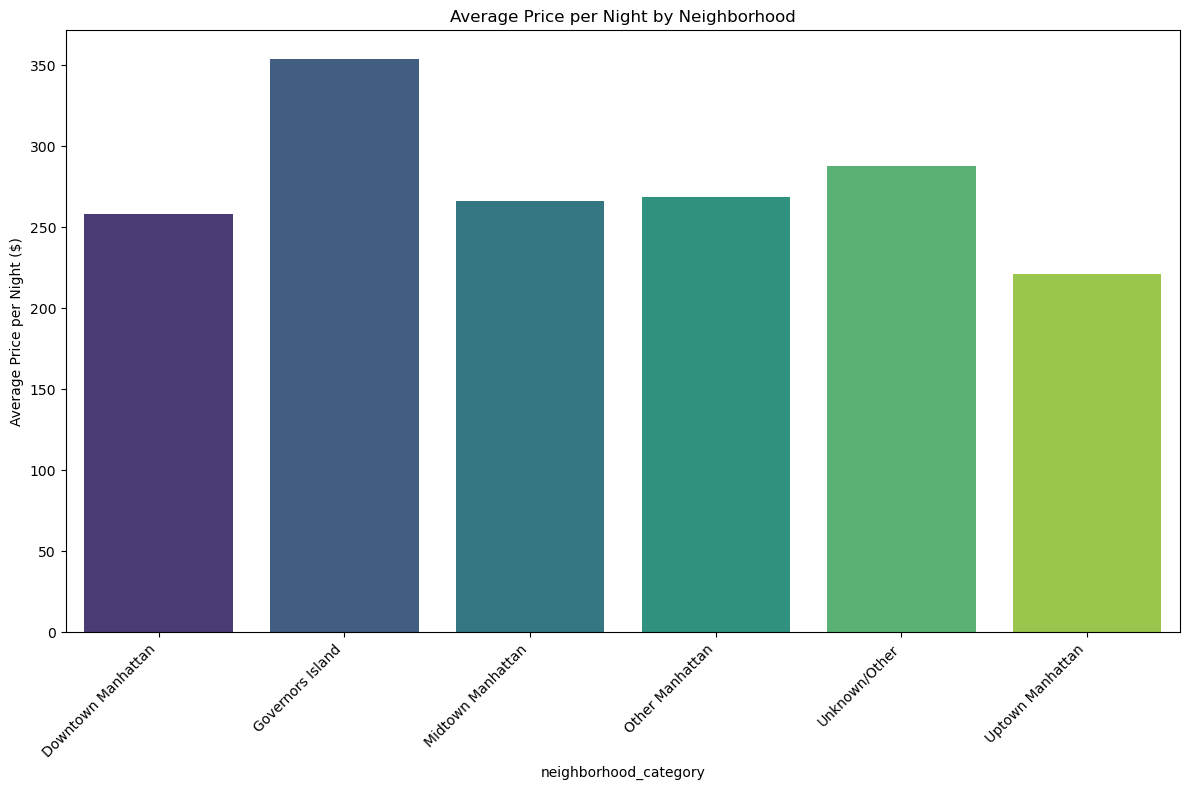

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv('United_cleaned_booking_hotels.csv')

# Check the price_per_night column
print("Sample data from the DataFrame:")
print(df[['neighborhood_category', 'price', 'los', 'price_per_night']].head(500))

# Ensure that the necessary columns exist and are in the correct format
df['price_per_night'] = df['price_per_night'].astype(float)
df['neighborhood_category'] = df['neighborhood_category'].astype(str)

# Calculate the average price per night for each neighborhood
avg_price_per_night = df.groupby('neighborhood_category')['price_per_night'].mean().reset_index()

# Check the average price per night
print("Average price per night for each neighborhood:")
print(avg_price_per_night)

# Plotting the average price per night for each neighborhood
plt.figure(figsize=(12, 8))
sns.barplot(x='neighborhood_category', y='price_per_night', data=avg_price_per_night, palette='viridis')
plt.xticks(rotation=45, ha='right')
plt.title('Average Price per Night by Neighborhood')
plt.xlabel('neighborhood_category')
plt.ylabel('Average Price per Night ($)')
plt.tight_layout()
plt.show()


C:\Users\ronro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ronro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ronro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\ronro\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating

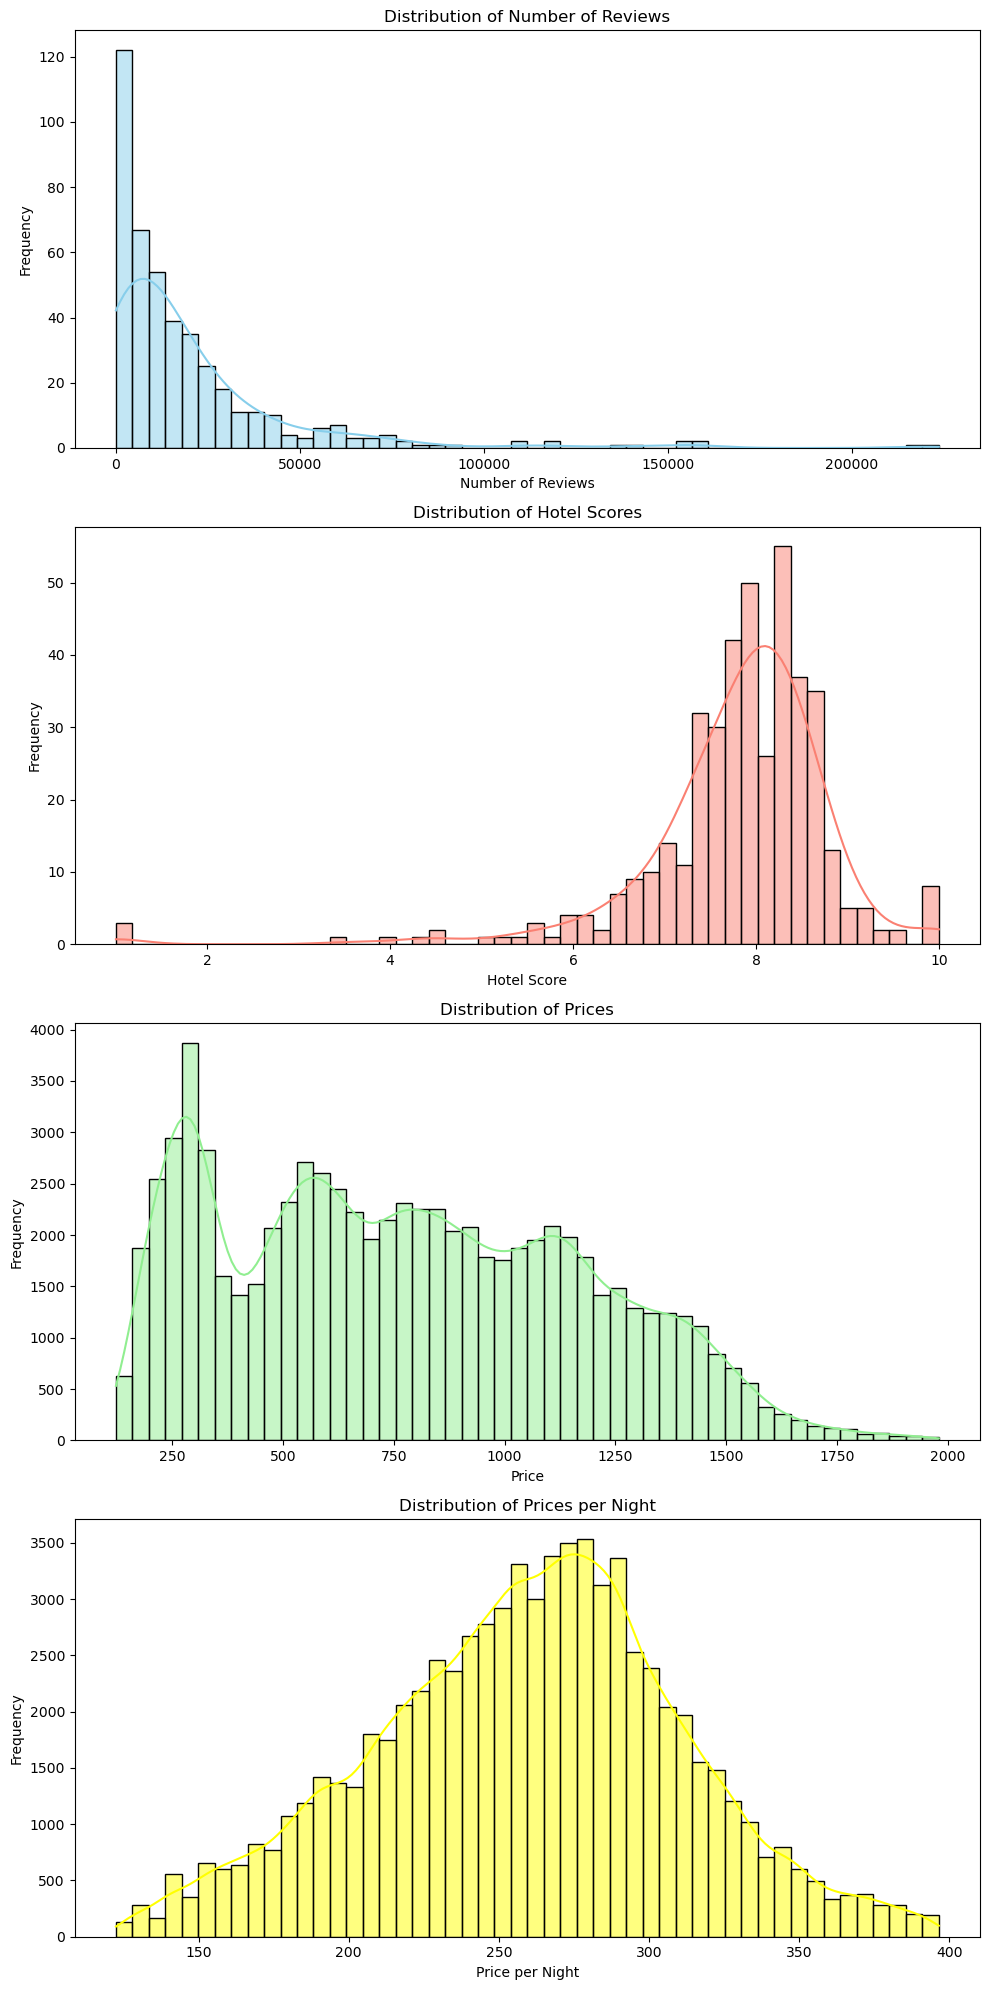

In [9]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
df = pd.read_csv('United_cleaned_booking_hotels.csv')

# Ensure the reviews column is treated as a string and clean it
df['reviews'] = df['reviews'].astype(str).str.replace(r'\D', '', regex=True)
df['reviews'] = df['reviews'].replace('', '0').astype(int)  # Replace empty strings with '0' and convert to int

# Clean the necessary columns
df['score'] = df['score'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
df['price'] = df['price'].astype(str).str.extract('(\d+\.?\d*)').astype(float)
df['price_per_night'] = df['price_per_night'].astype(str).str.extract('(\d+\.?\d*)').astype(float)

# Create a DataFrame where each hotel appears only once
df_unique_hotels = df.drop_duplicates(subset='name')

# Plot distributions using Seaborn for unique hotels
fig, axs = plt.subplots(4, 1, figsize=(10, 20))

# Number of reviews distribution
sns.histplot(df_unique_hotels['reviews'], bins=50, kde=True, ax=axs[0], color='skyblue')
axs[0].set_title('Distribution of Number of Reviews')
axs[0].set_xlabel('Number of Reviews')
axs[0].set_ylabel('Frequency')

# Hotel score distribution
sns.histplot(df_unique_hotels['score'], bins=50, kde=True, ax=axs[1], color='salmon')
axs[1].set_title('Distribution of Hotel Scores')
axs[1].set_xlabel('Hotel Score')
axs[1].set_ylabel('Frequency')

# Price distribution
sns.histplot(df['price'], bins=50, kde=True, ax=axs[2], color='lightgreen')
axs[2].set_title('Distribution of Prices')
axs[2].set_xlabel('Price')
axs[2].set_ylabel('Frequency')

# Price per night distribution
sns.histplot(df['price_per_night'], bins=50, kde=True, ax=axs[3], color='yellow')
axs[3].set_title('Distribution of Prices per Night')
axs[3].set_xlabel('Price per Night')
axs[3].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


## Insights on the distributions:
You can see in the graphs of the distributions we received that the distribution is relatively normal in the price per night columns, the hotel score
Whereas in the total price and number of reviews columns, the distribution is asymmetric to the right/positive.

The distribution of total prices does not update us too much because it makes sense to have more objects in the data whose prices are higher than the minimum prices.

The distribution of prices per night is not too new for us either, there is no reason why they should not be distributed in a normal way.

Regarding the distribution graph of the reviews, it can be understood that for the absolute majority of the hotels there are no more than 50,000 reviews.

Regarding the distribution graph of the hotel scores, you can see a normal distribution with most of the distributions ranging between scores 7.5 and 8.5.

In [1]:
import warnings

warnings.filterwarnings('ignore')

Data Types in Numeric DataFrame:
score                float64
reviews              float64
price                float64
star_rating          float64
location_rating      float64
free_cancellation      int64
limited_rooms          int64
ttt                    int64
breakfast              int64
index                  int64
km_from_center       float64
price_per_night      float64
room_rate              int64
dtype: object

First Few Rows of Numeric DataFrame:
    score  reviews  price  star_rating  location_rating  free_cancellation  \
1     6.6  13729.0  182.0          3.0              9.4                  0   
6     7.3   2434.0  239.0          3.0              9.4                  0   
7     8.0   2271.0  240.0          5.0              9.3                  0   
10    7.9   8398.0  243.0          4.0              9.4                  0   
13    8.6    477.0  255.0          3.0              9.8                  0   

    limited_rooms  ttt  breakfast  index  km_from_center  price_per_n

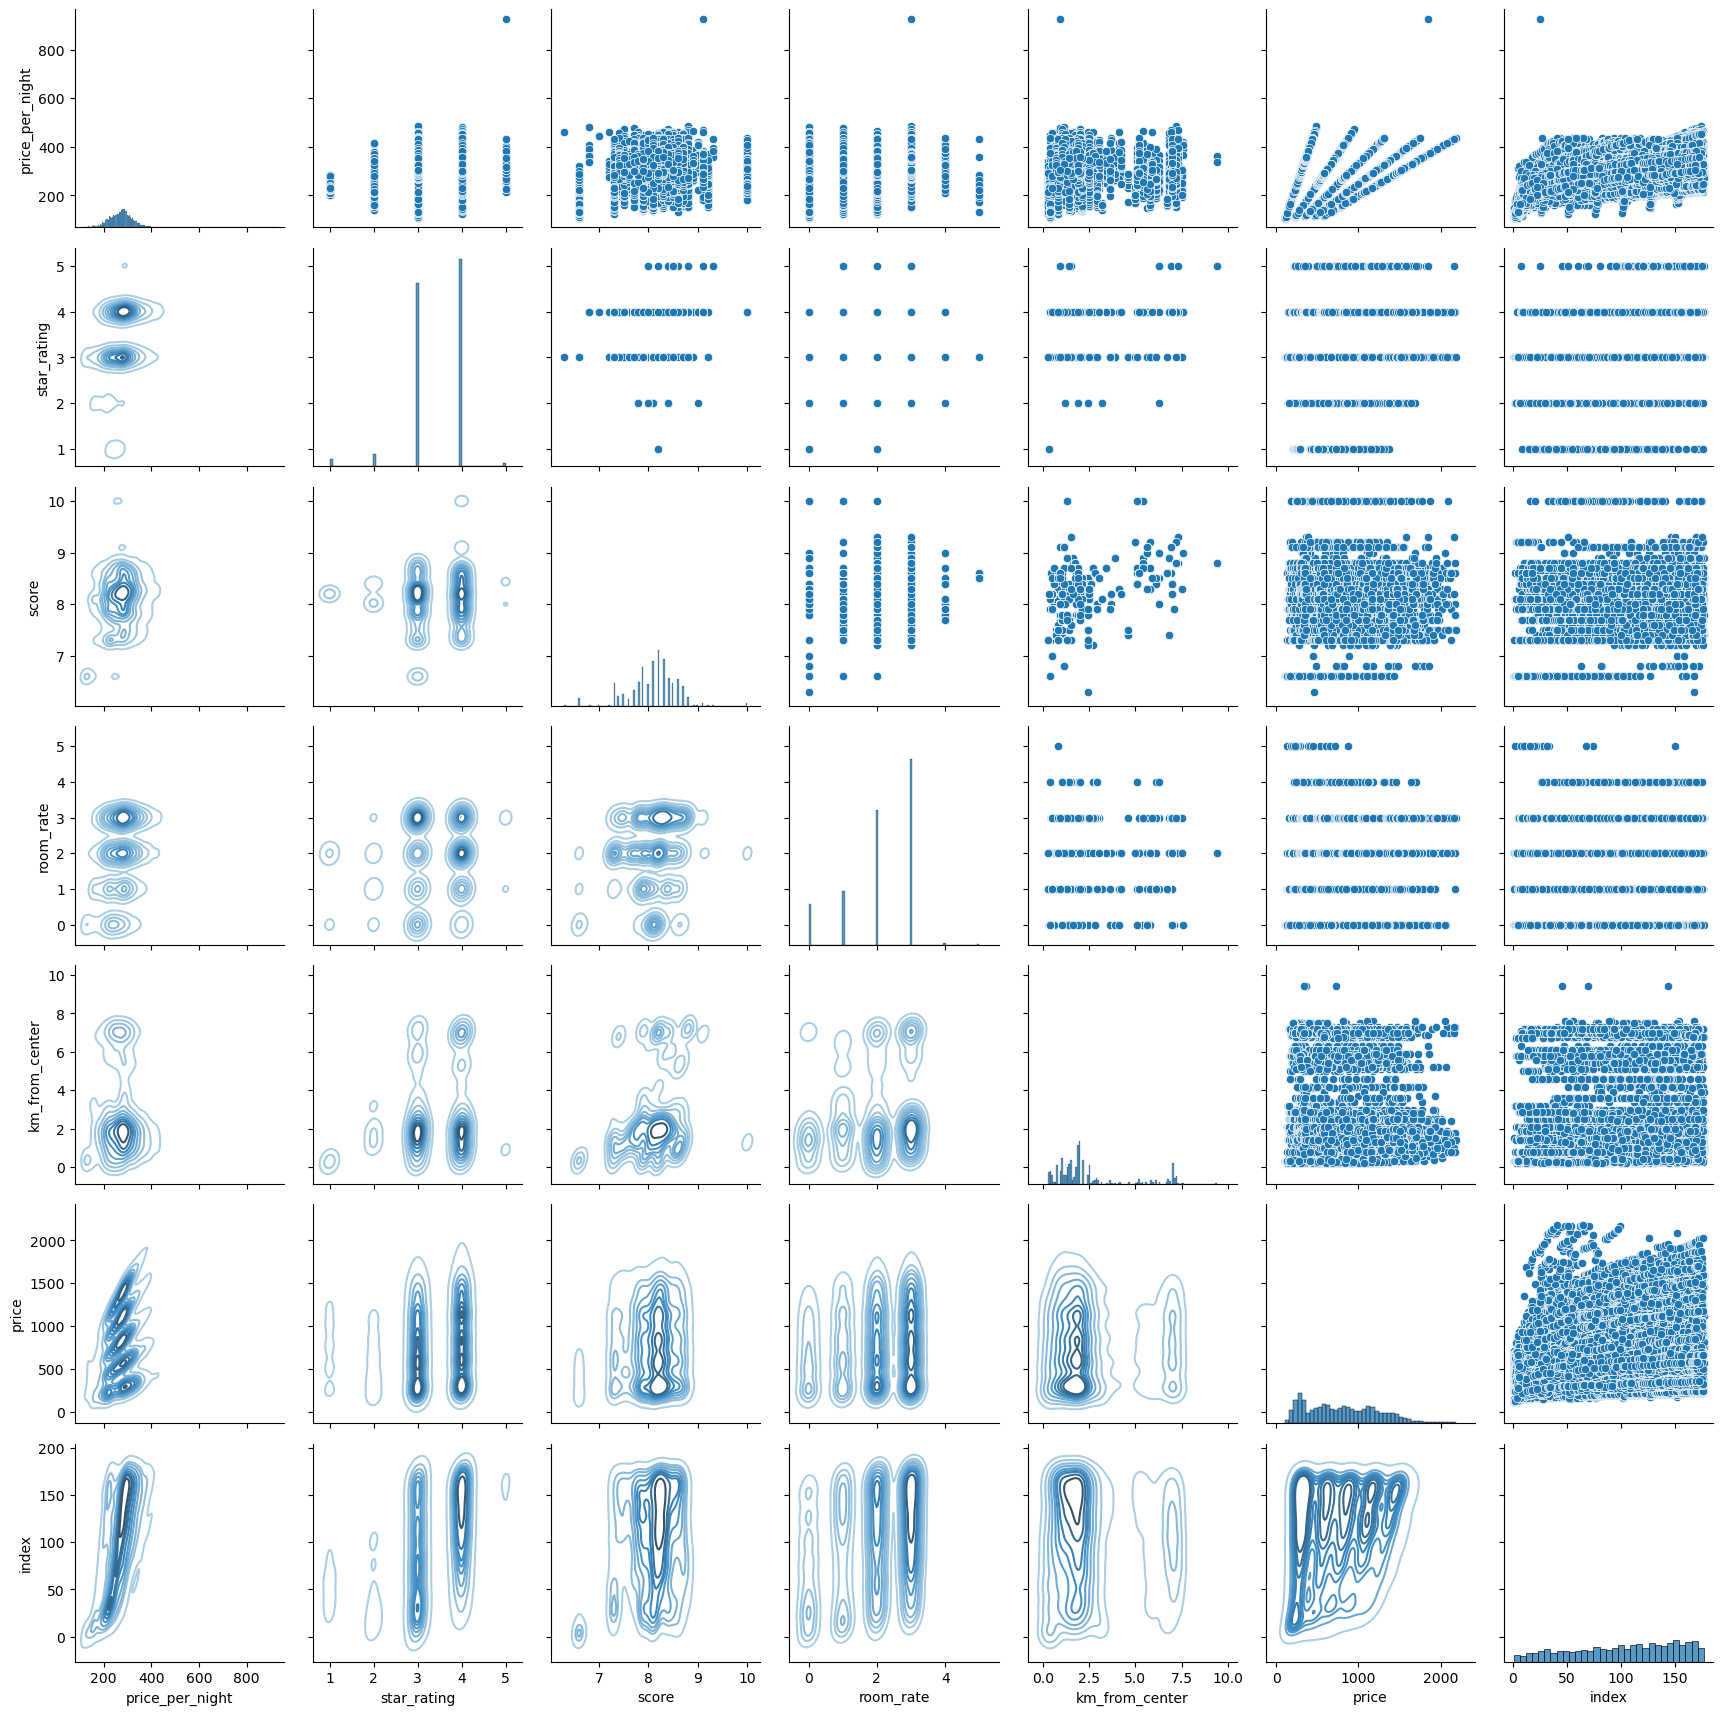

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('United_cleaned_booking_hotels.csv')

# Standardize the column names to lowercase
df.columns = [col.lower() for col in df.columns]

# Merge 'los' and 'los' columns
if 'los' in df.columns and 'los' in df.columns:
    df['los'] = df['los'].fillna(df['los'])
    df.drop(columns=['los'], inplace=True)
elif 'los' in df.columns:
    df['los'] = df['los']

# Drop 'location' column if it exists
df_temp = df.drop(columns=['location'], errors='ignore')

# Select only numeric columns
numeric_df = df_temp.select_dtypes(include=[float, int])

# Remove rows with null values in numeric columns
numeric_df = numeric_df.dropna()

# Verify the data types and the content of the dataframe
print("Data Types in Numeric DataFrame:")
print(numeric_df.dtypes)
print("\nFirst Few Rows of Numeric DataFrame:")
print(numeric_df.head())

# Check if we have any numeric columns left after dropping NA values
if numeric_df.empty:
    print("No numeric data available after preprocessing.")
else:
    # Calculate the correlation matrix
    correlation_matrix = numeric_df.corr()

    # Display the correlation matrix
    print("Correlation Matrix:")
    print(correlation_matrix)

    # Create a PairGrid to visualize pairwise relationships
    selected_features = ['price_per_night', 'star_rating', 'score', 'room_rate', 'km_from_center','price','index']
    g = sns.PairGrid(numeric_df, vars=selected_features)
    g.map_upper(sns.scatterplot)
    g.map_lower(sns.kdeplot, cmap='Blues_d')
    g.map_diag(sns.histplot, kde_kws={'color': 'k'})
    plt.show()


,star_rating,price_per_night
0,1.0,198.325044
1,2.0,225.037762
2,3.0,252.891209
3,4.0,275.068944
4,5.0,302.342349


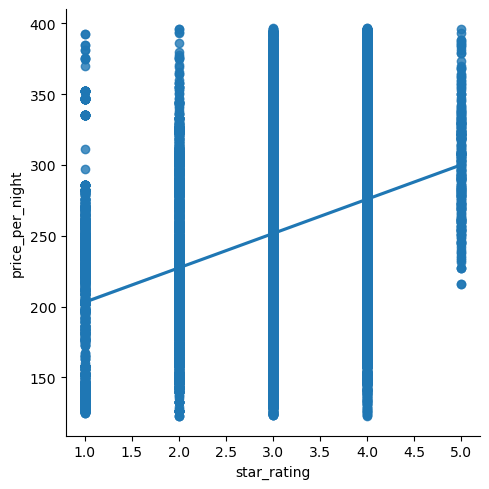

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
df = pd.read_csv('United_cleaned_booking_hotels.csv')

sns.lmplot(x='star_rating',y='price_per_night',data=df)


# Remove hotels that do not have a star rating
data_filtered = df.dropna(subset=['star_rating'])

# Group by star_rating and calculate the average price per night
average_prices = data_filtered.groupby('star_rating')['price_per_night'].mean().reset_index()

average_prices

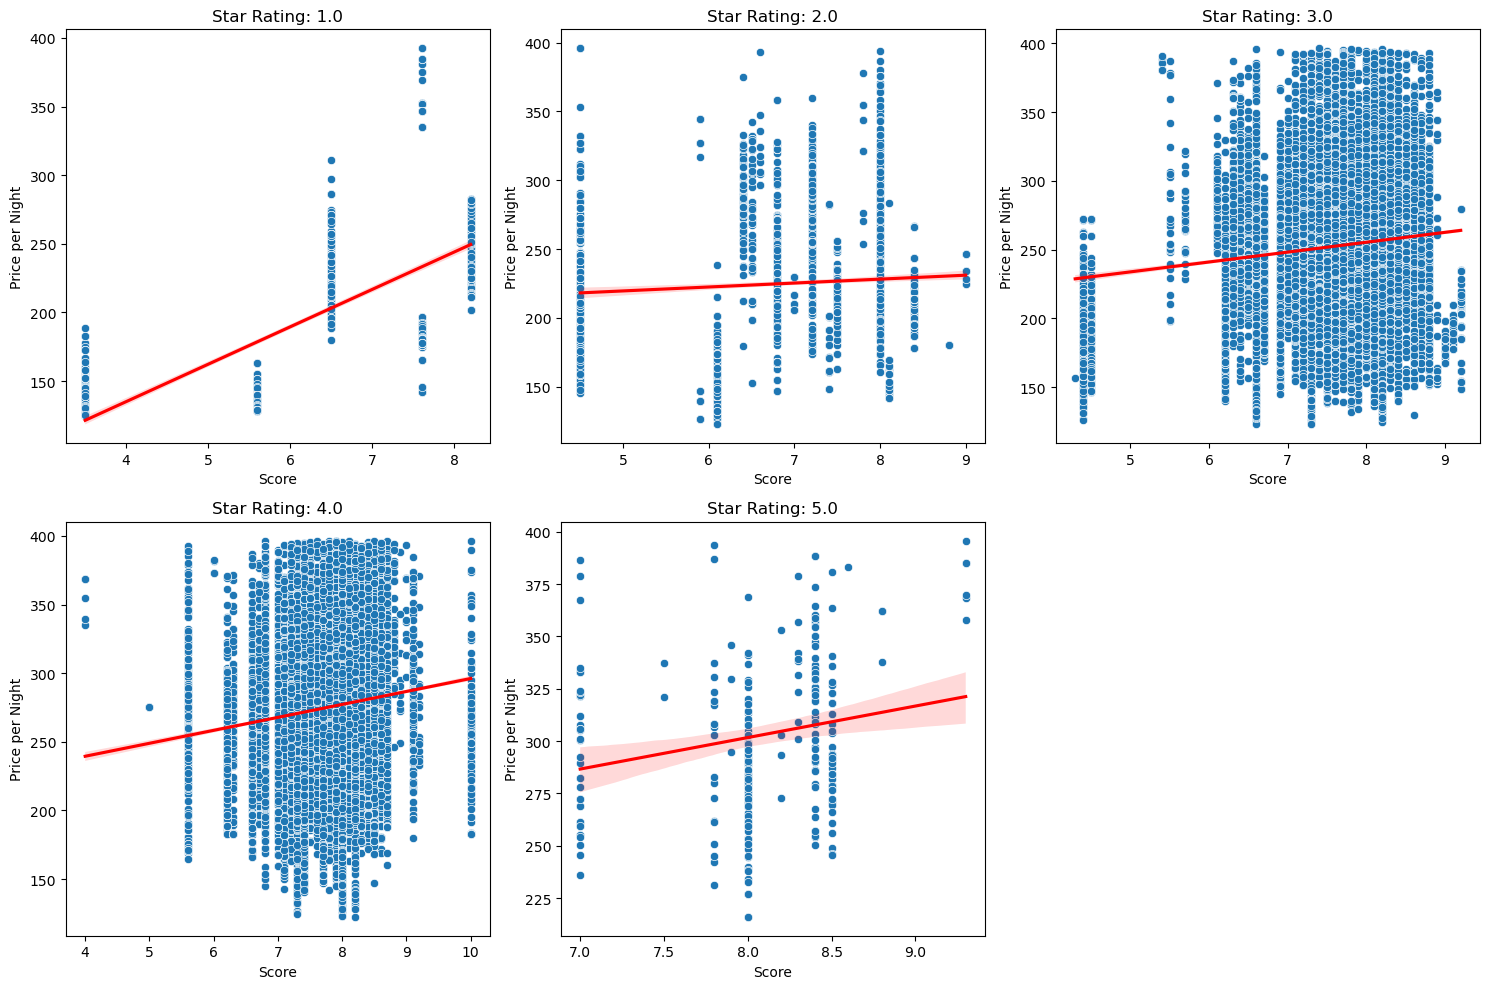

In [15]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the data
df = pd.read_csv('United_cleaned_booking_hotels.csv')

# Filter out hotels without a star rating
data_filtered = df.dropna(subset=['star_rating'])

# Get unique star ratings
unique_star_ratings = sorted(data_filtered['star_rating'].unique())

# Create subplots with regression lines
plt.figure(figsize=(15, 10))

for i, star in enumerate(unique_star_ratings, 1):
    plt.subplot(2, 3, i)
    star_data = data_filtered[data_filtered['star_rating'] == star]
    sns.scatterplot(x='score', y='price_per_night', data=star_data)
    sns.regplot(x='score', y='price_per_night', data=star_data, scatter=False, color='red')
    plt.title(f'Star Rating: {star}')
    plt.xlabel('Score')
    plt.ylabel('Price per Night')

plt.tight_layout()
plt.show()


## Conclusions  on the relationship between the score hotels received in booking and their price per night
In the graphs attached above, what we tried to do is check the effect of the opinion score on hotels at different levels.
We tried to do this using a regression line that would illustrate the linear relationship, if it exists at all.

We saw clear conclusions for hotels with one star - the higher the score on the website, the higher the price per night.


For the rest of the hotels in the other levels, the relationship between the score on the website and the price per night is weaker, although in all hotel groups you can see clear trend lines with relatively small slopes for hotels in the one star level.

In 5-star hotels you can see the "shadow" that surrounds the regression line and represents the confidence interval.

From this it is understood that the variation in the prices of 5-star hotels is high compared to the other groups of hotels, which increases the uncertainty in the connection between the grade and the price per night in this group.

In [3]:
import warnings

warnings.filterwarnings('ignore')

### What we will try to do in the two attached code sections is to check the relationship between the booking advance and the average price per night. I do this in order to understand whether there is any benefit in booking a vacation at a specific time before the vacation's start date.

### First we will try to see the average price per night for the 3 data sets in relation to TTT

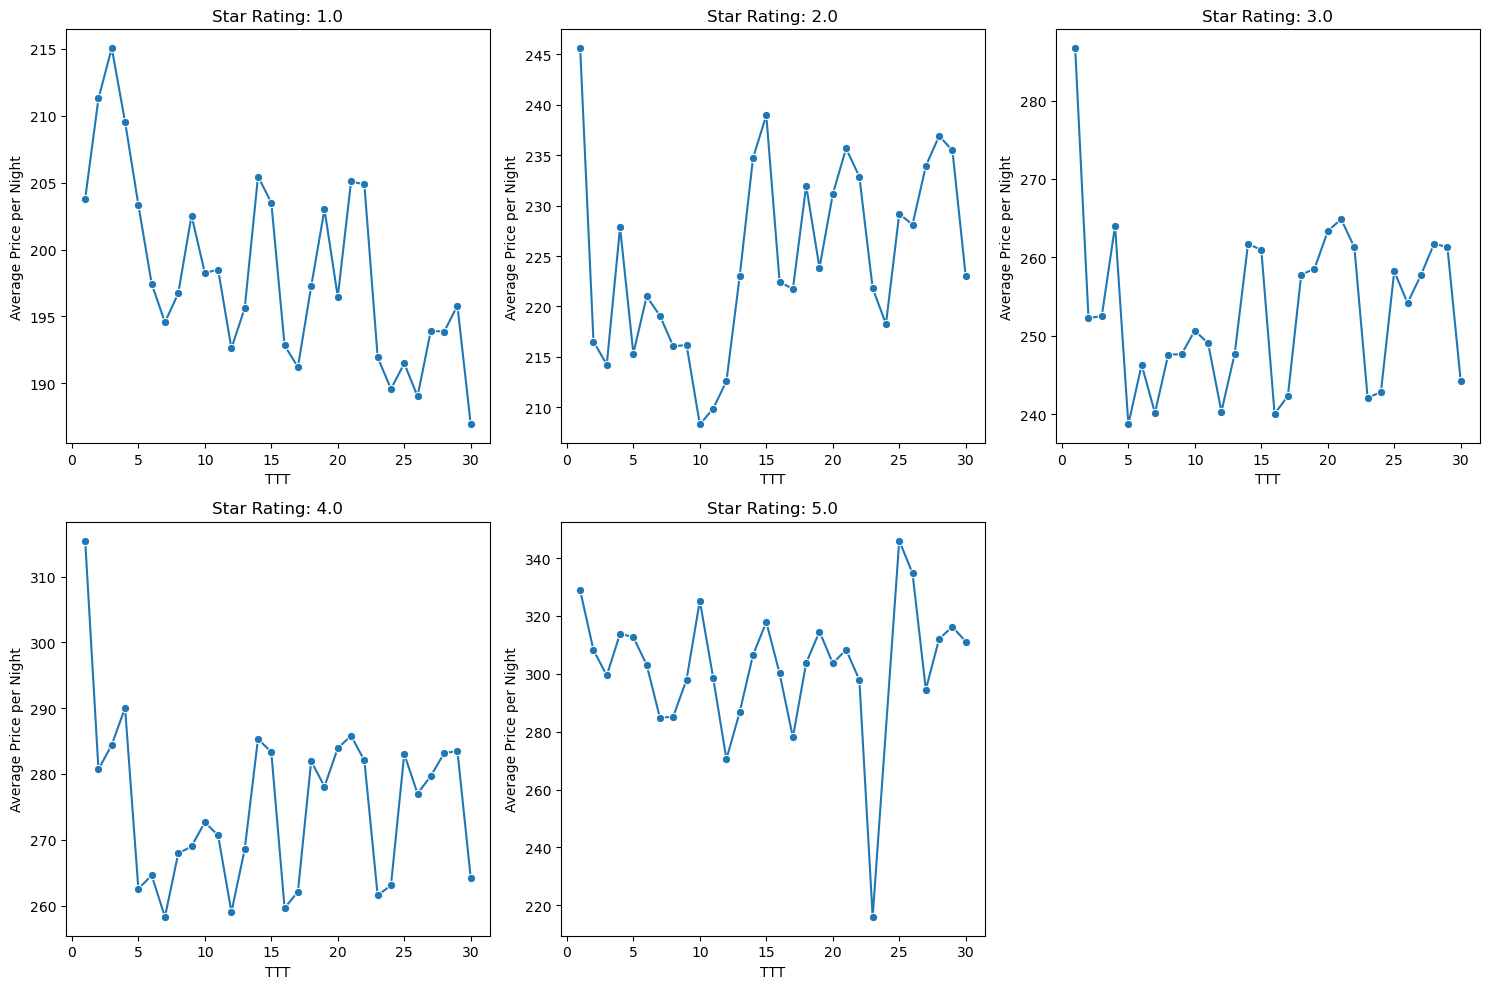

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('United_cleaned_booking_hotels.csv')

data_filtered = df.dropna(subset=['star_rating'])

# Group by star_rating and TTT, then calculate the average price per night
average_prices_ttt = data_filtered.groupby(['star_rating', 'TTT'])['price_per_night'].mean().reset_index()

# Plot the relationship
plt.figure(figsize=(15, 10))

unique_star_ratings = sorted(data_filtered['star_rating'].dropna().unique())

for i, star in enumerate(unique_star_ratings, 1):
    plt.subplot(2, 3, i)
    star_data = average_prices_ttt[average_prices_ttt['star_rating'] == star]
    sns.lineplot(x='TTT', y='price_per_night', data=star_data, marker='o')
    plt.title(f'Star Rating: {star}')
    plt.xlabel('TTT')
    plt.ylabel('Average Price per Night')

plt.tight_layout()
plt.show()





### In the graphs attached above, it can be seen that there is a relationship between the 2 variables and certain trends can be identified among hotels with different star ratings.

### Now we will try to check if the relationships are similar on all dates and then we can say that there are certain trends in the movement of the price per night in relation to TTT
### Or maybe the trends are different on different dates and then the confidence in the average trend will decrease significantly.

20_06_data - Average Prices by Star Rating and TTT
   star_rating  TTT  price_per_night
0          1.0    1       226.400000
1          1.0    2       236.903846
2          1.0    3       201.845139
3          1.0    4       205.459722
4          1.0    5       217.476667

25_06_data - Average Prices by Star Rating and TTT
   star_rating  TTT  price_per_night
0          1.0    1       192.522500
1          1.0    2       196.313333
2          1.0    3       206.993333
3          1.0    4       197.715909
4          1.0    5       174.664394

05_07_data - Average Prices by Star Rating and TTT
   star_rating  TTT  price_per_night
0          1.0    1       203.796667
1          1.0    2       211.296333
2          1.0    3       215.057062
3          1.0    4       209.548413
4          1.0    5       203.346354


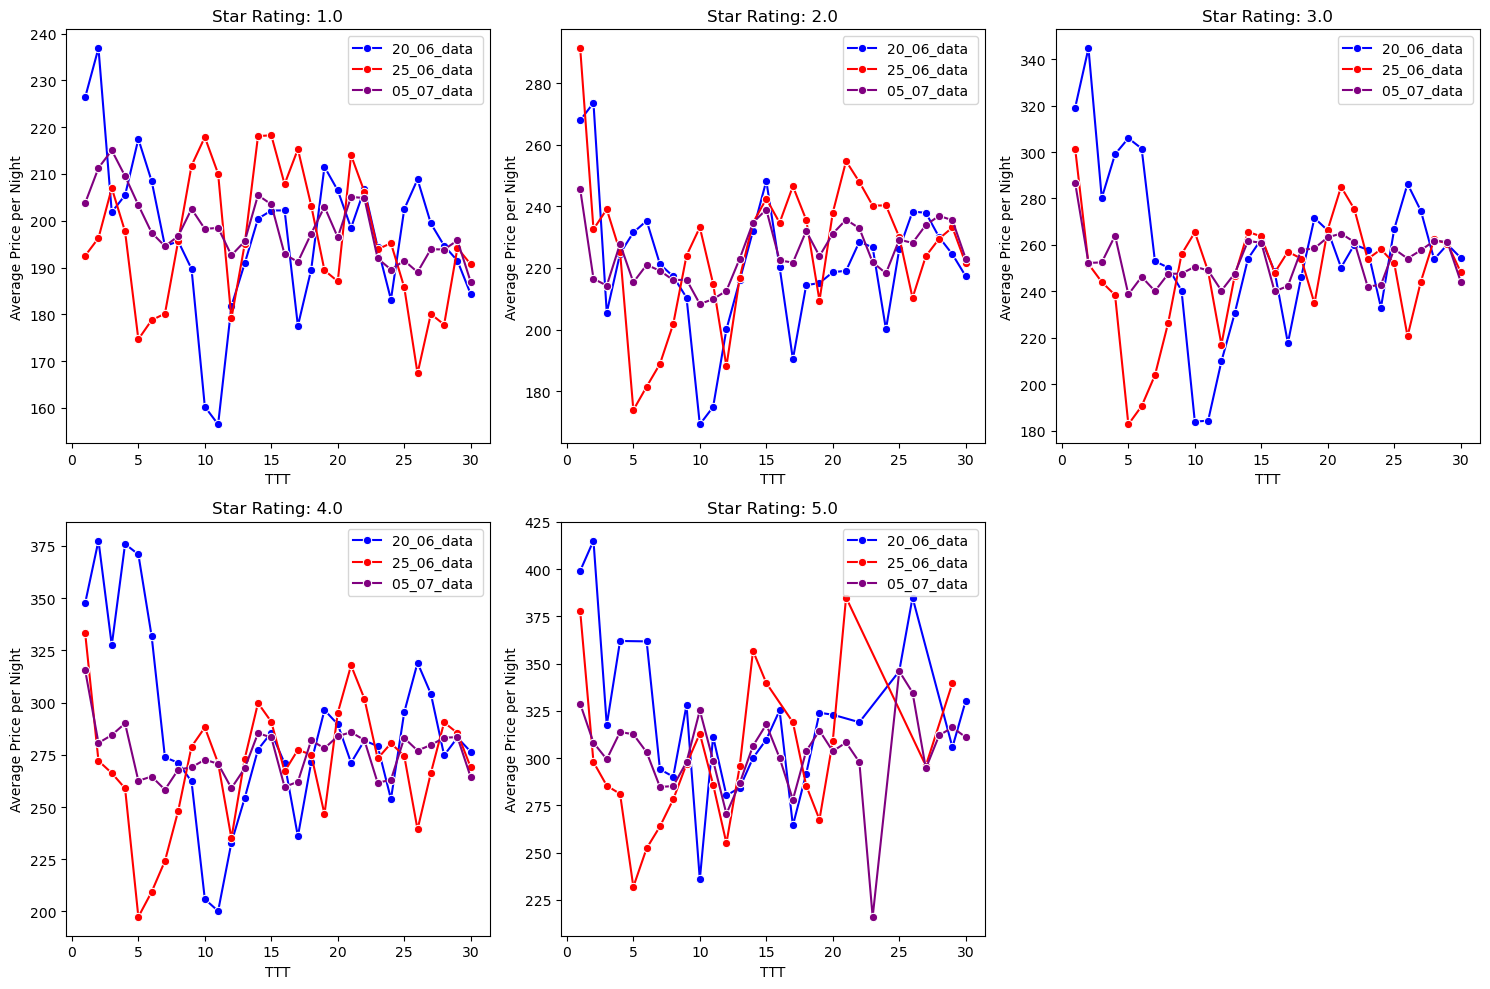

In [6]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the  data files
data1 = pd.read_csv('./20_06_hotels_data_cleaned.csv')      
data2 = pd.read_csv('./2506_cleaned_booking_hotels.csv')
data3 = pd.read_csv('./0507_cleaned_booking_hotels.csv')

# Remove hotels that do not have a star rating
data1_filtered = data1.dropna(subset=['star_rating'])
data2_filtered = data2.dropna(subset=['star_rating'])
data3_filtered = data3.dropna(subset=['star_rating'])

# Group by star_rating and TTT, then calculate the average price per night
average_prices_ttt1 = data1_filtered.groupby(['star_rating', 'TTT'])['price_per_night'].mean().reset_index()
average_prices_ttt2 = data2_filtered.groupby(['star_rating', 'TTT'])['price_per_night'].mean().reset_index()
average_prices_ttt3 = data3_filtered.groupby(['star_rating', 'TTT'])['price_per_night'].mean().reset_index()

# Debug prints to check data
print("20_06_data - Average Prices by Star Rating and TTT")
print(average_prices_ttt1.head())
print("\n25_06_data - Average Prices by Star Rating and TTT")
print(average_prices_ttt2.head())
print("\n05_07_data - Average Prices by Star Rating and TTT")
print(average_prices_ttt3.head())

# Plot the relationship
plt.figure(figsize=(15, 10))

unique_star_ratings = sorted(data1_filtered['star_rating'].dropna().unique())

for i, star in enumerate(unique_star_ratings, 1):
    plt.subplot(2, 3, i)
    
    star_data1 = average_prices_ttt1[average_prices_ttt1['star_rating'] == star]
    star_data2 = average_prices_ttt2[average_prices_ttt2['star_rating'] == star]
    star_data3 = average_prices_ttt3[average_prices_ttt3['star_rating'] == star]

    if not star_data1.empty:
        sns.lineplot(x='TTT', y='price_per_night', data=star_data1, marker='o', label='20_06_data', color='blue')
    if not star_data2.empty:
        sns.lineplot(x='TTT', y='price_per_night', data=star_data2, marker='o', label='25_06_data ', color='red')
    if not star_data3.empty:
        sns.lineplot(x='TTT', y='price_per_night', data=star_data3, marker='o', label='05_07_data ', color='purple')
    
    plt.title(f'Star Rating: {star}')
    plt.xlabel('TTT')
    plt.ylabel('Average Price per Night')
    plt.legend()

plt.tight_layout()
plt.show()


## Conclusions:

In the graphs attached above, of course, you can see that there is a significant difference in the average prices per night on the different snapshot dates (most likely this is because two of the dates were before American Independence Day, while the last one was after American Independence Day), but there are several points that indicate clear relative phenomena that can be visually identified and that confirm what which we saw in the previous graph:

1. In one-star hotels, there is a relatively clear downward trend in price in relation to TTT, meaning that the sooner we book within a 30-day period, the more likely the price of the reservation will drop.

2. In 2,3,4 star hotels you can see that the prices 5 days before the start date of the vacation reach a relative low on all the snapshot dates.

3. In all hotel groups except one-star hotels, in the range between 10-20 days before the start of the vacation there is a clear upward trend. That is, it can be assumed with relatively high certainty that it is better to book the vacation 10 days in advance and not 20 days in advance.

4. In all hotel groups, it will be clearly seen that booking 30 days before the start of the vacation is definitely cheaper than booking 20 days before the start of the vacation and 25 days before the start of the vacation. vacation.

###  Adding features - check-in day of the week, check-out day of the week and illustrating the relationship between them and the price per night using heatmap:

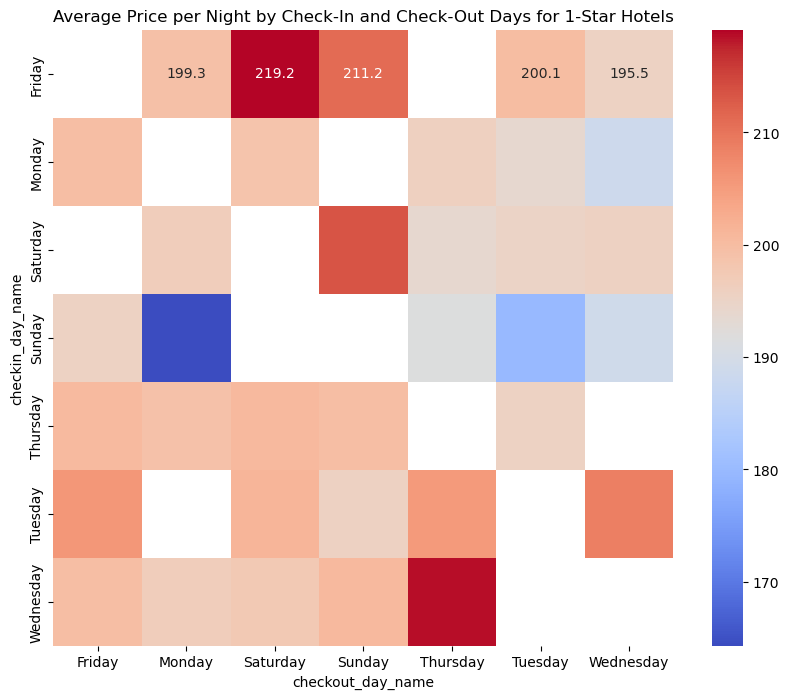

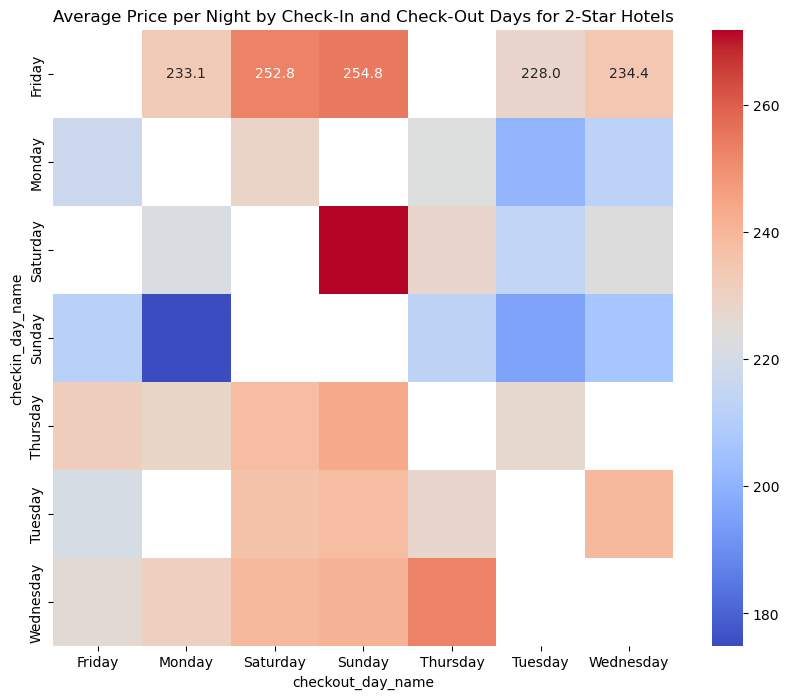

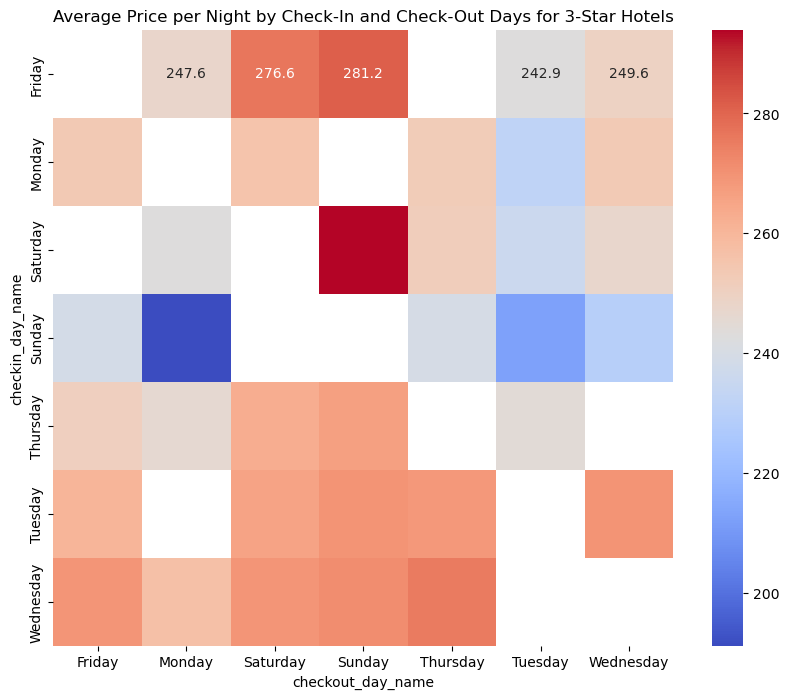

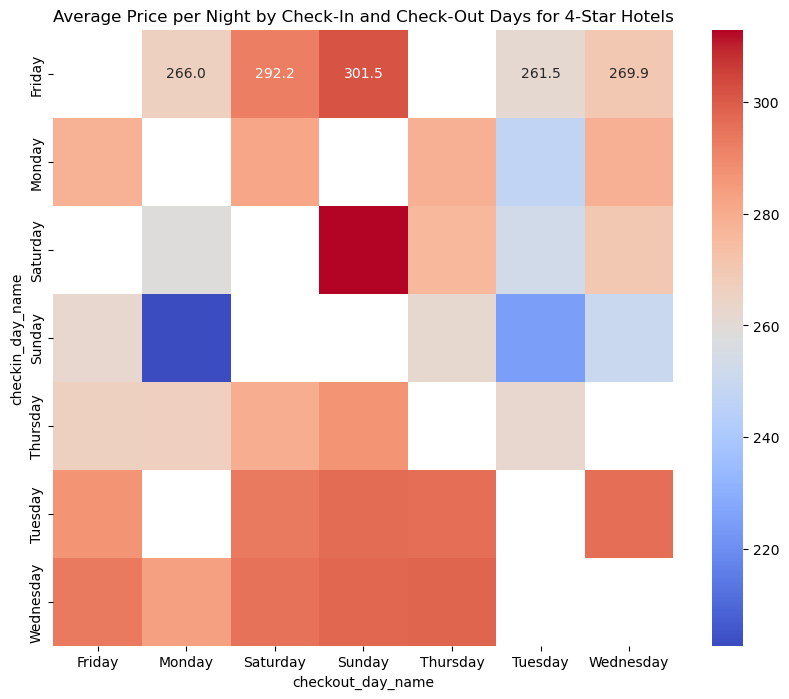

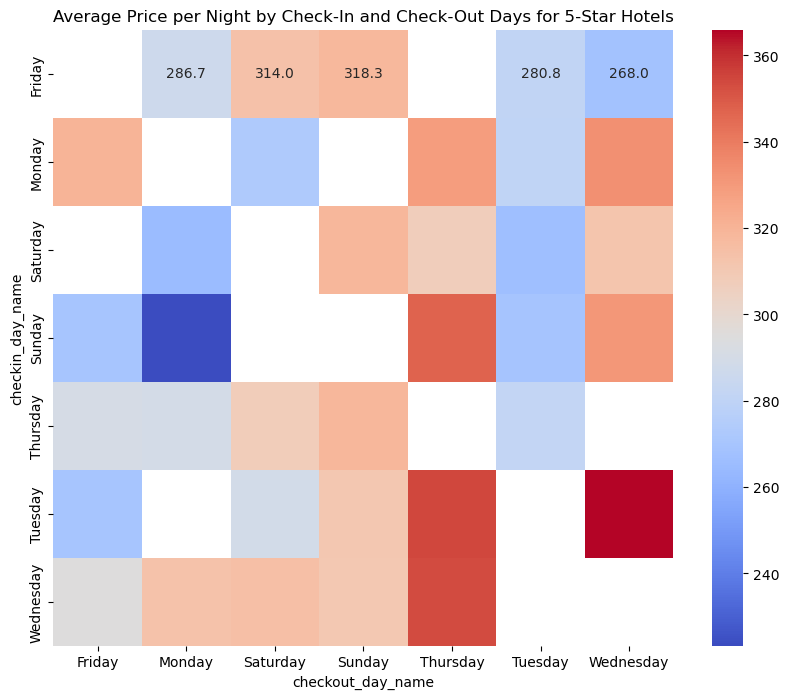

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file
df = pd.read_csv('United_cleaned_booking_hotels.csv')


# Ensure 'Snapshot' is in datetime format
df['Snapshot'] = pd.to_datetime(df['Snapshot'], errors='coerce')

# Ensure 'TTT' and 'LOS' are numeric
df['TTT'] = pd.to_numeric(df['TTT'], errors='coerce')
df['los'] = pd.to_numeric(df['los'], errors='coerce')

# Calculate check-in date by adding 'TTT' to 'Snapshot'
df['checkin'] = df['Snapshot'] + pd.to_timedelta(df['TTT'], unit='d')

# Calculate check-out date by adding 'LOS' to 'checkin'
df['checkout'] = df['checkin'] + pd.to_timedelta(df['los'], unit='d')

# Add columns for the day name of check-in and check-out
df['checkin_day_name'] = df['checkin'].dt.day_name()
df['checkout_day_name'] = df['checkout'].dt.day_name()

# Convert day names to categorical variables
df['checkin_day_name'] = df['checkin_day_name'].astype('category')
df['checkout_day_name'] = df['checkout_day_name'].astype('category')

# Identify and handle outliers in 'price_per_night'
df['price_per_night'] = pd.to_numeric(df['price_per_night'], errors='coerce')

# Remove rows where 'price_per_night' is less than a reasonable minimum price (e.g., $100)
df = df[df['price_per_night'] > 100]



# Prepare data for heatmaps based on star ratings
star_ratings = [1, 2, 3, 4, 5]
heatmap_data = {}
for star in star_ratings:
    heatmap_data[star] = df[df['star_rating'] == star].pivot_table(index='checkin_day_name', columns='checkout_day_name', values='price_per_night', aggfunc='mean')

# Create heatmaps for each star rating with annotations
for star in star_ratings:
    plt.figure(figsize=(10, 8))
    ax = sns.heatmap(heatmap_data[star], annot=True, fmt=".1f", cmap='coolwarm', cbar=True)
    plt.title(f'Average Price per Night by Check-In and Check-Out Days for {star}-Star Hotels')
    plt.show()

# Optionally, save the updated DataFrame to a new CSV file
df.to_csv('./United_hotels_data_cleaned_with_days_name_parameters.csv', index=False)

## Adding a new feature - a period of a month and then performing One hot encoding for the 3 new features we added:

In [14]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

df = pd.read_csv('./United_hotels_data_cleaned_with_days_name_parameters.csv')

# Ensure 'Snapshot' is in datetime format
df['Snapshot'] = pd.to_datetime(df['Snapshot'], errors='coerce')

# Ensure 'TTT' and 'LOS' are numeric
df['TTT'] = pd.to_numeric(df['TTT'], errors='coerce')
df['los'] = pd.to_numeric(df['los'], errors='coerce')

# Calculate check-in date by adding 'TTT' to 'Snapshot'
df['checkin'] = df['Snapshot'] + pd.to_timedelta(df['TTT'], unit='d')

# Calculate check-out date by adding 'LOS' to 'checkin'
df['checkout'] = df['checkin'] + pd.to_timedelta(df['los'], unit='d')

# Add columns for the day of the month for check-in and check-out
df['checkin_day'] = df['checkin'].dt.day
df['checkout_day'] = df['checkout'].dt.day

def determine_period(start_day, end_day):
    avg_day = (start_day + end_day) / 2
    if avg_day < 10:
        return 'beginning of the month'
    elif 10 <= avg_day < 22:
        return 'middle of the month'
    else:
        return 'end of the month'

# Apply the function to create the 'period_of_the_month' column
df['period_of_the_month'] = df.apply(lambda row: determine_period(row['checkin_day'], row['checkout_day']), axis=1)

# Perform one-hot encoding for 'checkin_day_name', 'checkout_day_name', and 'period_of_the_month'
checkin_encoder = OneHotEncoder(sparse=False)
encoded_checkin = checkin_encoder.fit_transform(df[['checkin_day_name']])

checkout_encoder = OneHotEncoder(sparse=False)
encoded_checkout = checkout_encoder.fit_transform(df[['checkout_day_name']])

period_encoder = OneHotEncoder(sparse=False)
encoded_period = period_encoder.fit_transform(df[['period_of_the_month']])

# Create DataFrames for the encoded columns
encoded_checkin_df = pd.DataFrame(encoded_checkin, columns=checkin_encoder.get_feature_names_out(['checkin_day_name']))
encoded_checkout_df = pd.DataFrame(encoded_checkout, columns=checkout_encoder.get_feature_names_out(['checkout_day_name']))
encoded_period_df = pd.DataFrame(encoded_period, columns=period_encoder.get_feature_names_out(['period_of_the_month']))

# Drop the original columns and concatenate the new one-hot encoded columns
df = df.drop(columns=['checkin_day_name', 'checkout_day_name', 'period_of_the_month'])
df = df.join(encoded_checkin_df).join(encoded_checkout_df).join(encoded_period_df)

# Save the updated DataFrame to a new CSV file
output_file = './United_hotels_data_cleaned_with_days_name_parameters_period_encoded.csv'
df.to_csv(output_file, index=False)



## Illustration of the effect of the period of the month on the price per night:

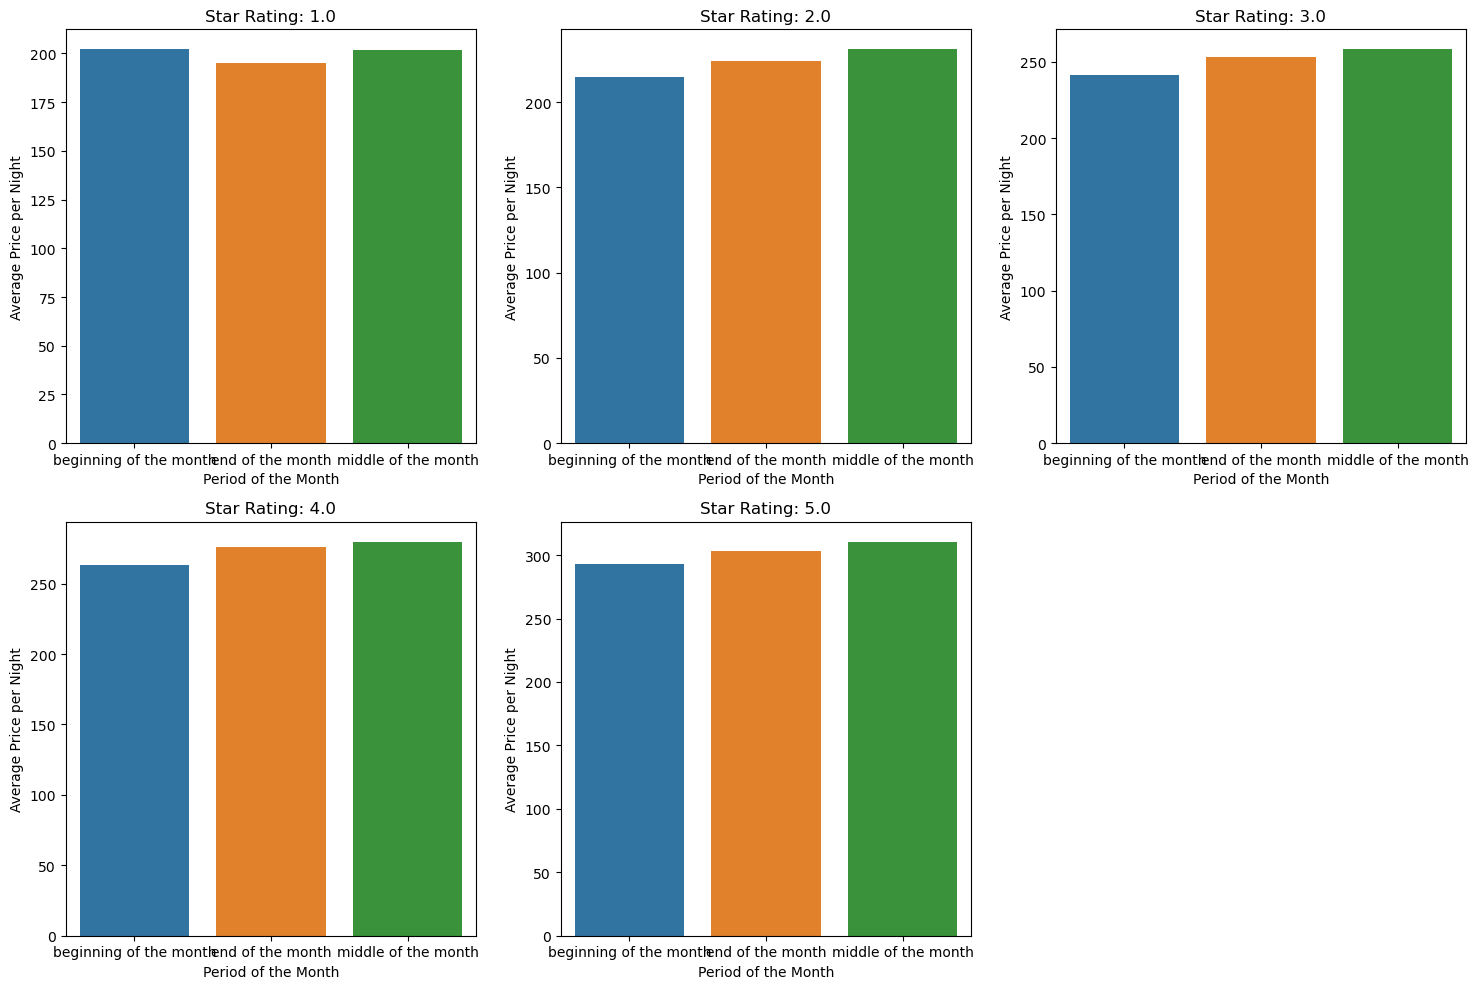

In [15]:
df = pd.read_csv('United_cleaned_booking_hotels.csv')

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


# Load the CSV file
df = pd.read_csv('./United_hotels_data_cleaned_with_days_name_parameters_period_encoded.csv')

def decode_period(row):
    if row['period_of_the_month_beginning of the month'] == 1.0:
        return 'beginning of the month'
    elif row['period_of_the_month_middle of the month'] == 1.0:
        return 'middle of the month'
    elif row['period_of_the_month_end of the month'] == 1.0:
        return 'end of the month'
    return 'unknown'

# Apply the function to create the 'period_of_the_month' column
df['period_of_the_month'] = df.apply(decode_period, axis=1)
average_price_per_period = df.groupby(['star_rating', 'period_of_the_month'])['price_per_night'].mean().reset_index()


# Get unique star ratings
unique_star_ratings = average_price_per_period['star_rating'].unique()

# Create subplots for each star rating
plt.figure(figsize=(15, 10))

for i, star in enumerate(unique_star_ratings, 1):
    plt.subplot(2, 3, i)
    star_data = average_price_per_period[average_price_per_period['star_rating'] == star]
    sns.barplot(data=star_data, x='period_of_the_month', y='price_per_night')
    plt.title(f'Star Rating: {star}')
    plt.xlabel('Period of the Month')
    plt.ylabel('Average Price per Night')

plt.tight_layout()
plt.show()


### Conclusion:
It can be seen that with the exception of one-star hotels where a vacation at the beginning of the month is the most expensive, there is a clear trend of price increases from the beginning of the month to the end.